In [28]:
from random import shuffle
from turtle import forward
import torch
import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
#     [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
# )

import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cpu')

In [29]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [46]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(900, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 900)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

In [47]:
net = CNNNet()
net.to(device)

print(net)

CNNNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [48]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [49]:
#开始训练
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("Finished training.")

[1,  2000] loss: 1.627
[1,  4000] loss: 1.254
[1,  6000] loss: 1.153
[1,  8000] loss: 1.105
[1, 10000] loss: 1.075
[1, 12000] loss: 1.057
[1, 14000] loss: 1.026
[2,  2000] loss: 0.852
[2,  4000] loss: 0.876
[2,  6000] loss: 0.840
[2,  8000] loss: 0.835
[2, 10000] loss: 0.638
[2, 12000] loss: 0.608
[2, 14000] loss: 0.585
[3,  2000] loss: 0.576
[3,  4000] loss: 0.567
[3,  6000] loss: 0.562
[3,  8000] loss: 0.550
[3, 10000] loss: 0.551
[3, 12000] loss: 0.562
[3, 14000] loss: 0.547
Finished training.


In [52]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

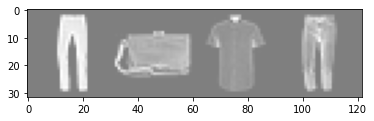

Trouser Bag   Shirt Trouser


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size = 4

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

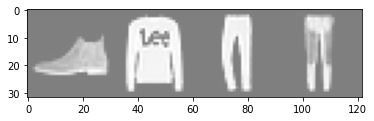

GroundTruth:  Ankle Boot Pullover Trouser Trouser


In [54]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [55]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  T-shirt Pullover Trouser Trouser


In [56]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


In [57]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt is 75.7 %
Accuracy for class: Trouser is 96.6 %
Accuracy for class: Pullover is 82.5 %
Accuracy for class: Dress is 88.6 %
Accuracy for class: Coat  is 75.3 %
Accuracy for class: Sandal is 97.7 %
Accuracy for class: Shirt is 74.0 %
Accuracy for class: Sneaker is 97.2 %
Accuracy for class: Bag   is 97.2 %
Accuracy for class: Ankle Boot is 0.0 %


# 后面是md测试，请忽略（卑微）

# 哈哈

## 你好

哈哈
===

白日依山尽。
（哈哈）

黄河入海流

可以吗*哈哈*

不行哦**呵呵**

>hehe

>hehe

># hehe

这是一个[链接](https://baidu.com)哈哈

so do [i](https://baidu.com)

引用式[链接][1]链接

[1]: http://baidu.com

- apple
- pineapple
- coconut
+ hehe
* haha

Android `nihao `

```cpp
printf("hello world");
if (a == 0) {
    cout << "hi";
}
```

nihao
- - -
nihao

|编号|name|age|gender|
|:-----:|:---------------------|:--------:|:------:|
|0|mike|28|male|
|1|sarah|20|female|

- wash dishes

后面三个字打上~~删除线~~

# 流程图
------
小明的老婆叫他买一斤包子，如果路上看到卖西瓜的，买一个。

```flow
A(get out) --> B(whether watermelon)
B --> |yes|C(one baozi)
B --> |no|D(one kilo baozi)
```

# mathematical formula
-------
block $$f(x_1, x_2\dots,x_n)=x_1^2+x_2^2+\dots+x_n^2$$
line $f(x_1, x_2\dots,x_n)=x_1^2+x_2^2+\dots+x_n^2$

举个例子 $a^{w^i_j}$
- - -
once again $$a^{w^i_j}$$
- - -
$$a^{1+1}$$
- - -
$$\sqrt[3]{a+b}$$

$$\frac{dy}{dx}$$

$$\sum_{i=1}^{10}a_i$$

$$\int_{-\infty}^{\infty}f(x)dx$$
- - -
$$
\left(
\begin{matrix}
    1&0&0\\
    0&1&0\\
    0&0&1
\end{matrix}
\right)
$$

$$
\left|
\begin{matrix}
    1&0&0\\
    0&1&0\\
    0&0&1
\end{matrix}
\right|\tag{1}
$$

$$
\gamma \not \subseteq \Omega
$$
$$
a \equiv b

$$
AB\perp CD
$$
$$
f(x)=\frac{1}{1+e^{-x}}\tag{sigmoid}


```python
def ReLU(x):
    return max(x, 0)
```